<a href="https://colab.research.google.com/github/sangeethsajeev/capstone_project/blob/master/FinalSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bi-Directional LSTM
[Dataset - Beijing PM2.5](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data)

Air pollution exerts critically bad influence on human health. Among many other metrics, PM2.5 is one crucial indicator of air quality. Particulate Matter(PM 2.5) consist of particles with diameter less than 2.5 micrometer. Here we have dataset of PM2.5 level from Bejing. Each record in dataset represents the level of pollution(PM2.5) at an particular hour on a particular date.

We will predict PM2.5 value for an hour based on previous N (4 or 6) hours.

In [ ]:
#import required packages
import numpy
import pandas
from matplotlib import pyplot 
from math import sqrt
from datetime import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import seaborn as sns

In [ ]:
#download the data
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv

In [ ]:
#load the data
df = read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

In [ ]:
df.head(3)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0


In [ ]:
#Drop non-feature columns
for col in ['No', 'year', 'month', 'day', 'pm2.5_new']:
  df.drop(col, axis=1, inplace=True, errors='ignore')

In [ ]:
#set user friendly column names
df.columns = ['Hour','PM25', 'Dew','Temperature', 'Pressure', 'WindDirection', 'WindSpeed', 'Snow', 'Rain']

In [ ]:
df.describe()

,Hour,PM25,Dew,Temperature,Pressure,WindSpeed,Snow,Rain
count,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [ ]:
#Remove errorneous records
df.dropna(inplace=True)
df.shape

(41757, 9)

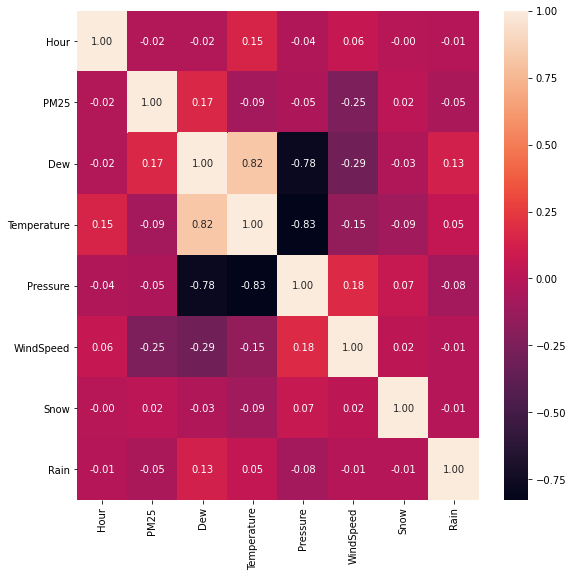

In [ ]:
#Check for correlation
corr_matrix = df.corr()
fig, ax = pyplot.subplots(figsize=(9,9))
sns.heatmap(corr_matrix, vmax=1.0, fmt='.2f', annot=True)

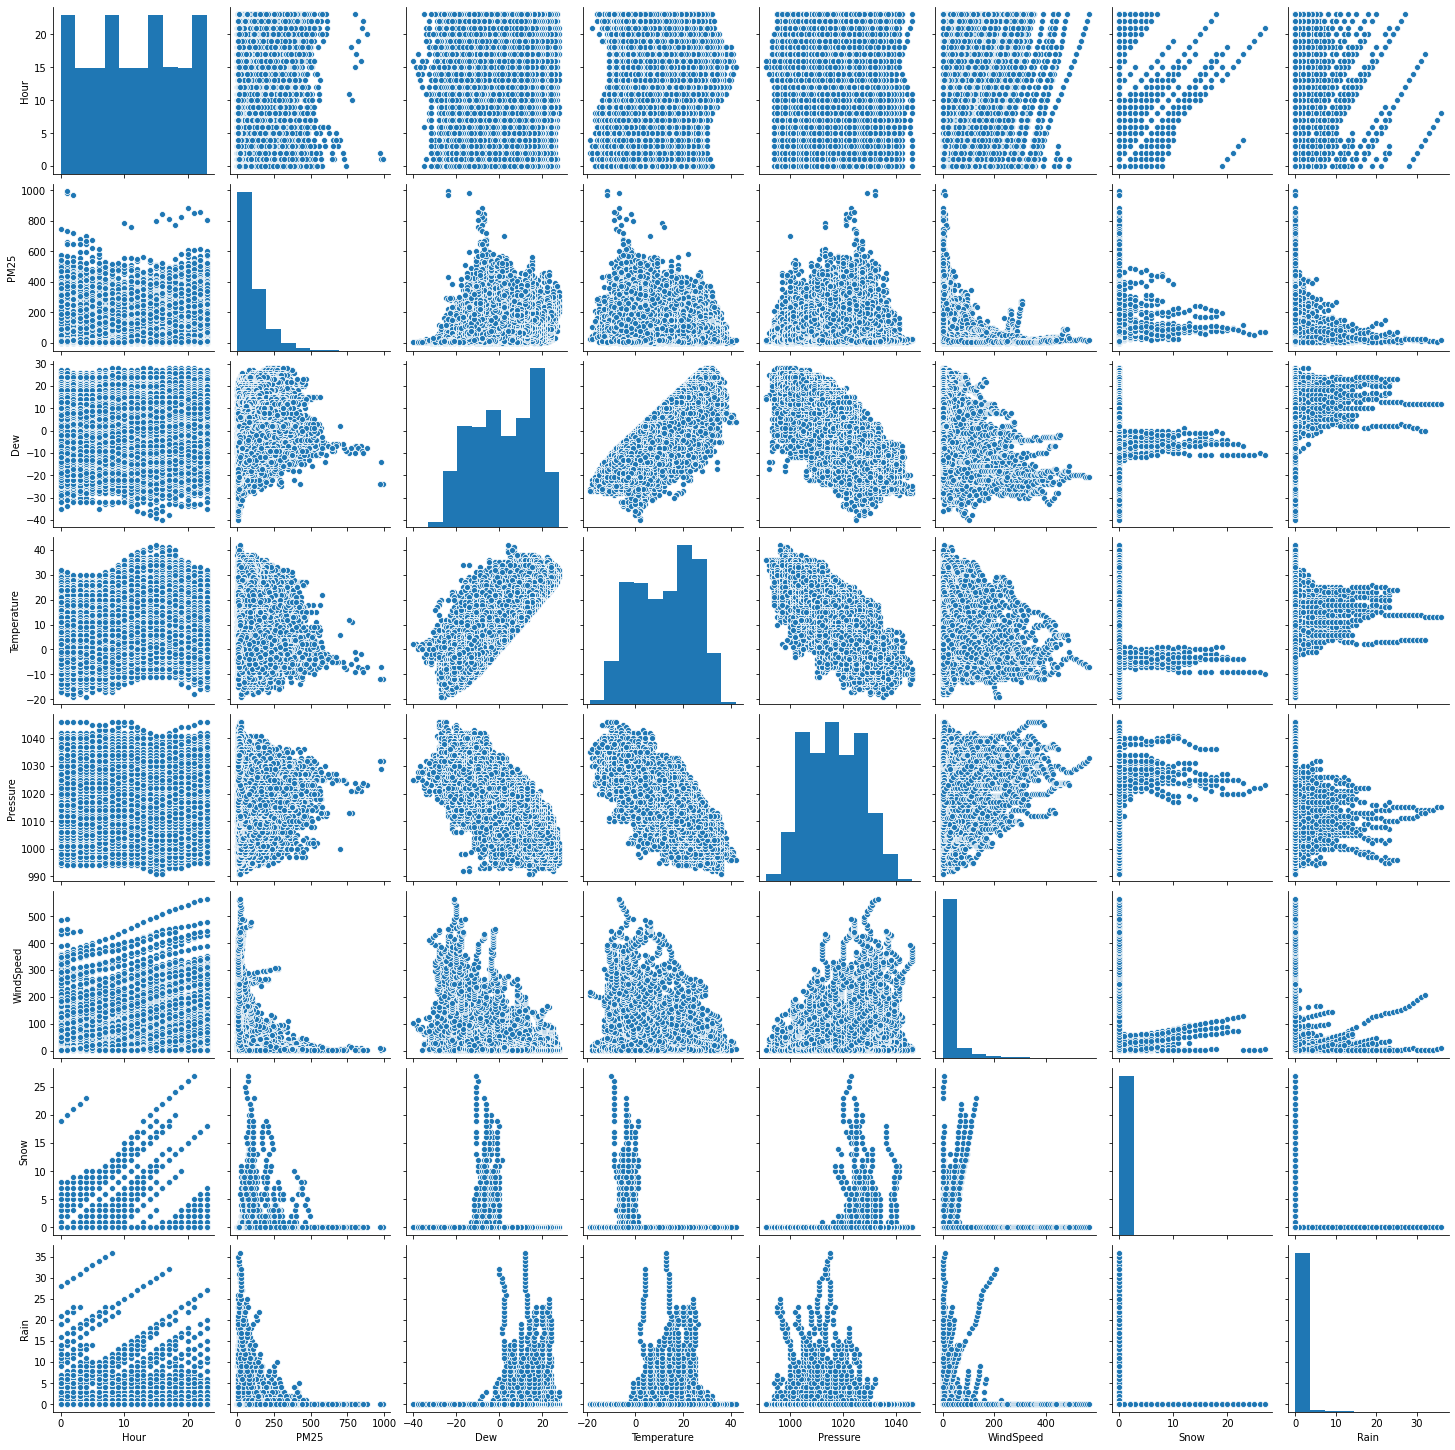

In [ ]:
#See data distribution with each other
pairplot = sns.pairplot(df)

## Feature Engineering/Transformation
Label Encoding & Scaling

In [ ]:
labelencoder = LabelEncoder()
df['WindDirection'] = labelencoder.fit_transform(df['WindDirection'])

min_max_scaler = MinMaxScaler()
for col in df.columns:
  if col == 'PM25':
    continue
  else:
    df[col] = min_max_scaler.fit_transform(df[[col]])

In [ ]:
df.head(3)

,Hour,PM25,Dew,Temperature,Pressure,WindDirection,WindSpeed,Snow,Rain
24,0.000000,129.0,0.352941,0.245902,0.527273,0.666667,0.002372,0.0,0.0
25,0.043478,148.0,0.367647,0.245902,0.527273,0.666667,0.003947,0.0,0.0
26,0.086957,159.0,0.426471,0.229508,0.545455,0.666667,0.005522,0.0,0.0


## Converting raw data to Time Series Data

In [ ]:
# convert multiple records into 1 record having history of last n hours of data as attributes
def transform_data_many_to_one(data, columns, time_steps=1):
  n_vars = data.shape[1]
  dataset = DataFrame(data)
  cols, names = list(), list()
  for i in range(time_steps, 0, -1):
    cols.append(dataset.shift(i))
    names += [('{}(t-{})'.format(columns[j], i)) for j in range(n_vars)]
  cols.append(dataset.shift(-0))
  names += [('{}(t)'.format(columns[j])) for j in range(n_vars)]
  new_df = concat(cols, axis=1)
  new_df.columns = names
  new_df.dropna(inplace=True)
  return new_df

In [ ]:
values = df.values
values = values.astype('float32')
n_hours = 4 #6
n_features = 9
transformed_df = transform_data_many_to_one(values, df.columns, n_hours)
transformed_df.drop(['Hour(t)', 'Dew(t)','Temperature(t)', 'Pressure(t)', 'WindDirection(t)', 'WindSpeed(t)', 'Snow(t)', 'Rain(t)'], axis=1, inplace=True)
transformed_df.reset_index(drop=True, inplace=True)
transformed_df.head(2)

,Hour(t-4),PM25(t-4),Dew(t-4),Temperature(t-4),Pressure(t-4),WindDirection(t-4),WindSpeed(t-4),Snow(t-4),Rain(t-4),Hour(t-3),PM25(t-3),Dew(t-3),Temperature(t-3),Pressure(t-3),WindDirection(t-3),WindSpeed(t-3),Snow(t-3),Rain(t-3),Hour(t-2),PM25(t-2),Dew(t-2),Temperature(t-2),Pressure(t-2),WindDirection(t-2),WindSpeed(t-2),Snow(t-2),Rain(t-2),Hour(t-1),PM25(t-1),Dew(t-1),Temperature(t-1),Pressure(t-1),WindDirection(t-1),WindSpeed(t-1),Snow(t-1),Rain(t-1),PM25(t)
0,0.000000,129.0,0.352941,0.245902,0.527273,0.666667,0.002372,0.0,0.0,0.043478,148.0,0.367647,0.245902,0.527273,0.666667,0.003947,0.0,0.0,0.086957,159.0,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0,0.130435,181.0,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0,138.0
1,0.043478,148.0,0.367647,0.245902,0.527273,0.666667,0.003947,0.0,0.0,0.086957,159.0,0.426471,0.229508,0.545455,0.666667,0.005522,0.0,0.0,0.130435,181.0,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0,0.173913,138.0,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0,109.0


We will train our network on first 3 years of data(60%), next one 1 year's data for validation(20%) and last  1 year's records for testing(20%).

In [ ]:
values = transformed_df.values
n_train_hours = 365*24*3 # 3 for 3 years
train = values[:n_train_hours, :]
validate = values[n_train_hours:n_train_hours+8740, :] #kept 1 year data for validation
test = values[n_train_hours+8740:, :] # 1 year data for test
n_attributes = n_hours * n_features
train_X, train_y = train[:, :n_attributes], train[:, -1]
test_X, test_y = test[:, :n_attributes], test[:, -1]
validate_X, validate_y = validate[:, :n_attributes], validate[:, -1]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
validate_X = validate_X.reshape((validate_X.shape[0], n_hours, n_features))

In [ ]:
print(train_y.shape, validate_y.shape, test_y.shape)

(26280,) (8740,) (6733,)


## Neural Network

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='selu', return_sequences=True), input_shape=(n_hours, n_features)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='selu', return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='selu')))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 4, 128)            37888     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 128)            98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               71600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 208,405
Trainable params: 208,405
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [ ]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(validate_X, validate_y), verbose=0, shuffle=False)

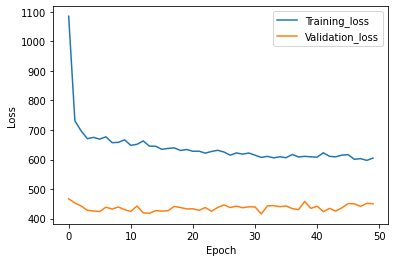

In [ ]:
pyplot.plot(history.history['loss'], label='Training_loss')
pyplot.plot(history.history['val_loss'], label='Validation_loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

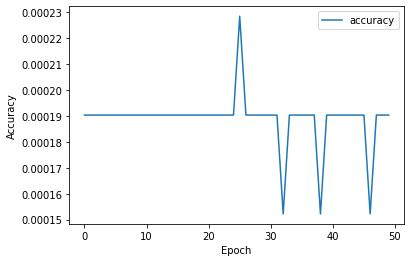

In [ ]:
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.show()

In [ ]:
test_X.shape

(6733, 36)

## Making Predictions

In [ ]:
# predictions = []
# for i in range(test_X.shape[0]-n_hours+1):
#   x_input = test_X[i:i+n_hours]
#   x_input = x_input.reshape((n_hours, n_hours, n_features))
#   prediction = model.predict(x_input, verbose=0)
#   predictions.append(prediction[0][0])
#   if i%1000==0 and i>0:
#     print("Predictions done for {} records".format(i))

predictions = []
for i in range(n_hours, test_X.shape[0]):
  if test_X.shape[0] < n_hours:
    print("Not enough Samples for prediction")
    break
  x_input = test_X[i-n_hours:i]
  x_input = x_input.reshape((n_hours, n_hours, n_features))
  prediction = model.predict(x_input, verbose=0)
  predictions.append(prediction[0][0])
  if i%1000==0 and i>0:
    print("Predictions done for {} records".format(i))

Predictions done for 1000 records
Predictions done for 2000 records
Predictions done for 3000 records
Predictions done for 4000 records
Predictions done for 5000 records
Predictions done for 6000 records


In [ ]:
res_arr = numpy.array(predictions)
res_arr = res_arr.reshape(len(res_arr), 1)

## Plot results from predictions

###### Plotting only 100 values to convey the difference clearly.

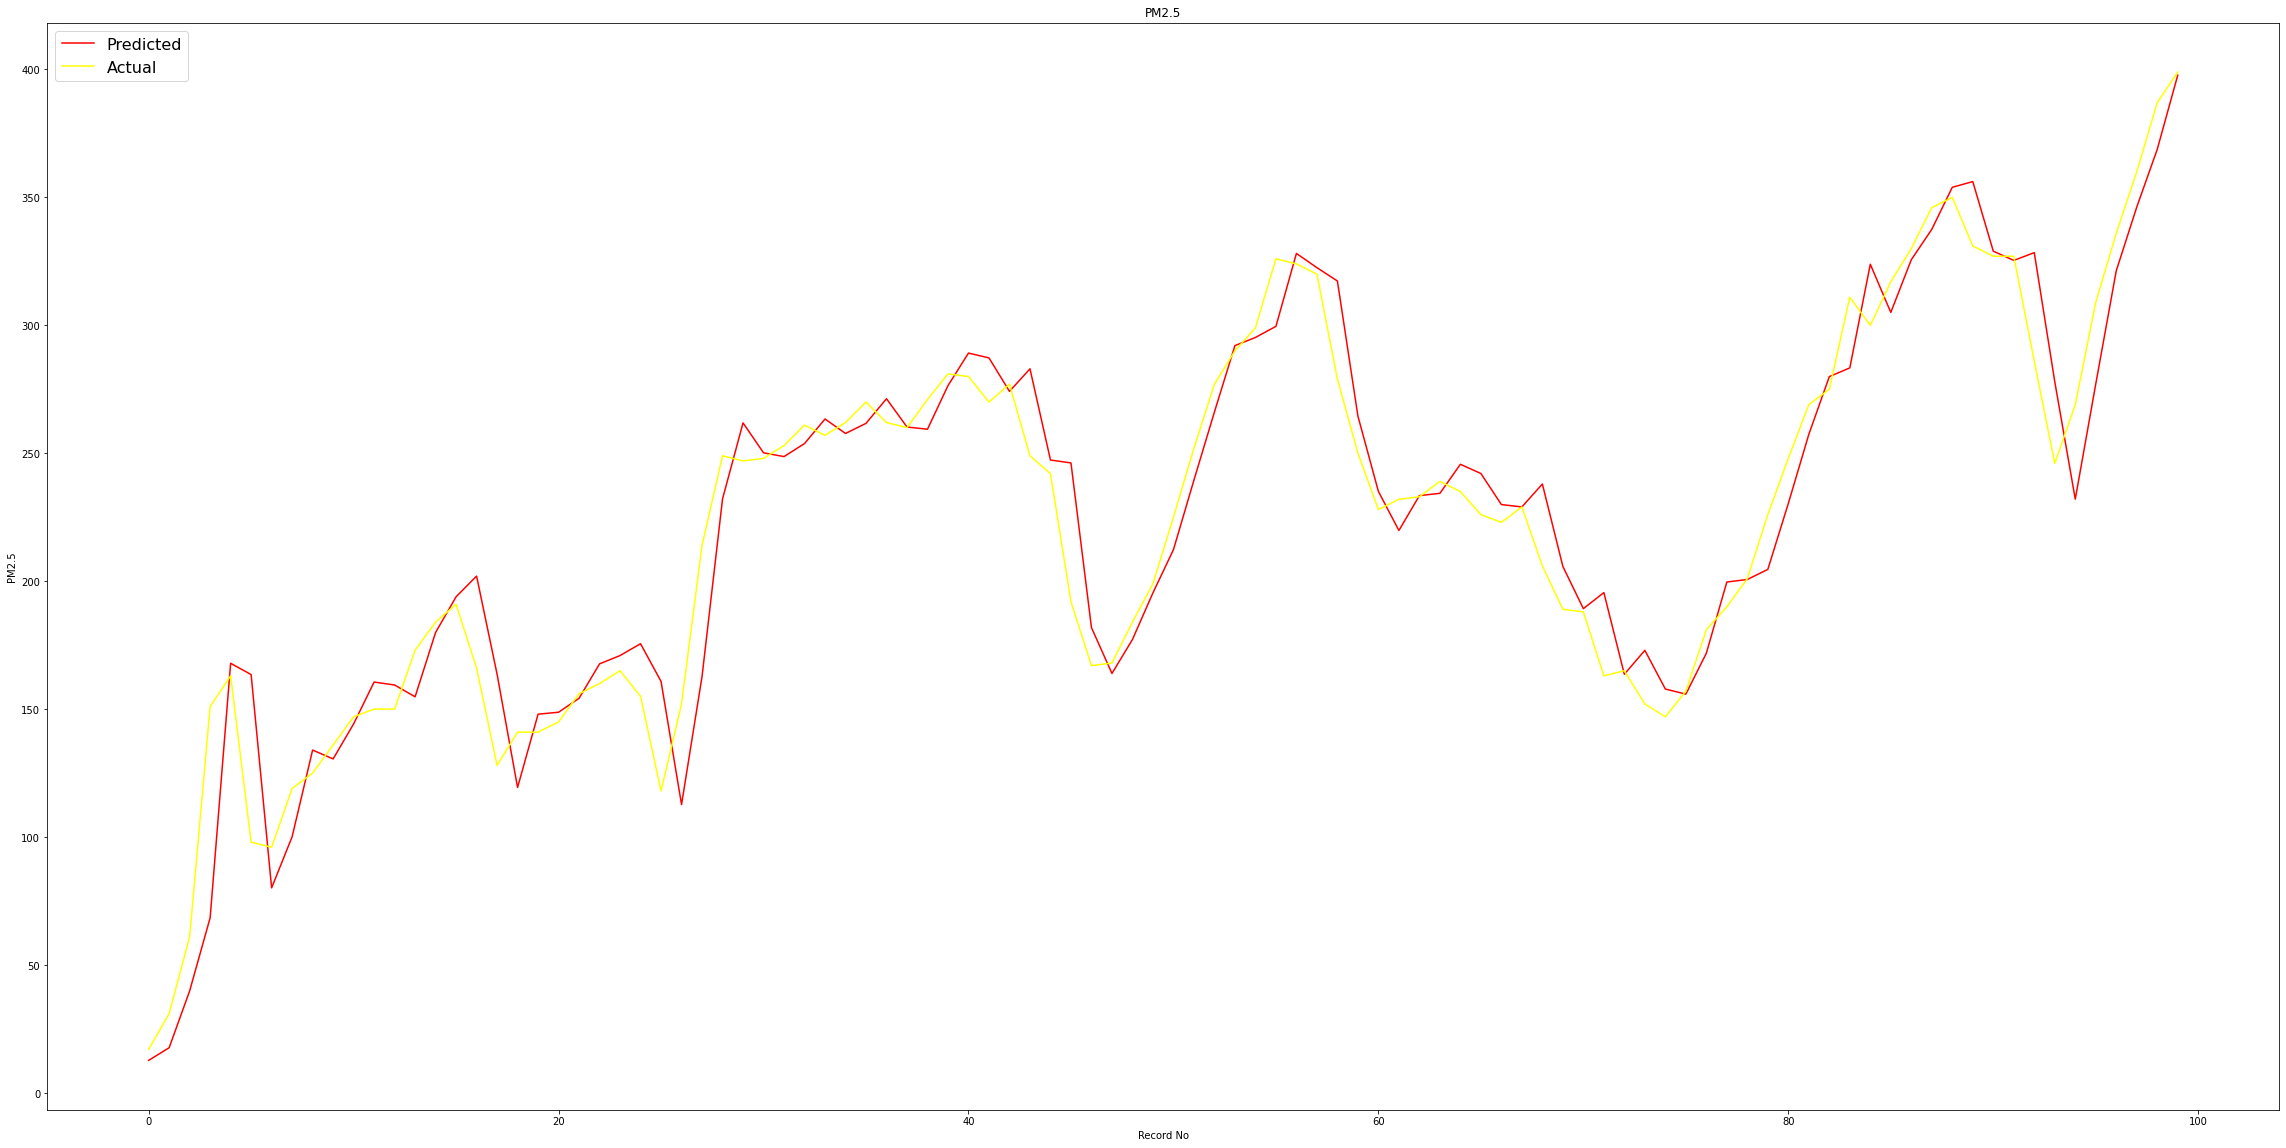

In [ ]:
pyplot.figure(figsize=(40,20))
pyplot.title('PM2.5')
pyplot.xlabel('Record No')
pyplot.ylabel('PM2.5')
pyplot.plot(res_arr[:100], color='red')
pyplot.plot(test[n_hours:, 1:2][:100], color='yellow')
pyplot.legend(('Predicted', 'Actual'), loc='best', fontsize=16)
pyplot.show()

## Model Evaluation Metric

In [ ]:
rmse = sqrt(mean_squared_error(res_arr[:], test[n_hours:, 1:2]))
print('RMSE Score: {}'.format(rmse))


RMSE Score: 20.85543326521143


Save Our model

In [ ]:
#model.save_weights('Bi-DirectionalLSTM.h5')